<a href="https://colab.research.google.com/github/pariscwang/toronto-childcare-analysis/blob/main/Toronto_Childcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive

# Setting up

In [3]:
# Import data
xls = pd.read_excel("/content/Toronto Childcare Data.xlsx", sheet_name=['ChildCareCentres', 'DataDictionary'])
df = xls['ChildCareCentres']
feature_dict_df = xls['DataDictionary']

In [4]:
df.head(3)

_id  LOC_ID                                        LOC_NAME  \
0    1    1013           Lakeshore Community Child Care Centre   
1    2    1014         Alternative Primary School Parent Group   
2    3    1015  Cardinal Leger Child Care Centre (Scarborough)   

             AUSPICE          ADDRESS    PCODE  ward  \
0  Non Profit Agency   101 SEVENTH ST  M8V 3B5     3   
1  Non Profit Agency  1100 SPADINA RD  M5N 2M6     8   
2  Non Profit Agency   600 MORRISH RD  M1C 4Y1    25   

                    bldg_type                         BLDGNAME  IGSPACE  \
0    Public Elementary School     Seventh Street Public School        0   
1    Public Elementary School  North Preparatory Public School        0   
2  Catholic Elementary School   Cardinal Leger Catholic School        0   

   TGSPACE  PGSPACE  KGSPACE  SGSPACE  TOTSPACE subsidy cwelcc_flag  \
0       20       32       52       60       164       Y           Y   
1        0       12       26       45        83       Y           Y   
2       10       16       26       50       102       Y           Y   

   Unnamed: 17  
0          NaN  
1          NaN  
2          NaN

In [5]:
df = df.drop('Unnamed: 17',axis=1)
df.describe().T

count         mean          std     min     25%     50%      75%  \
_id       1063.0   532.000000   307.005972     1.0   266.5   532.0    797.5   
LOC_ID    1063.0  8087.888053  5151.252693  1013.0  1862.0  8826.0  13245.0   
ward      1063.0    12.511759     7.032050     1.0     6.0    12.0     19.0   
IGSPACE   1063.0     3.896519     6.091782     0.0     0.0     0.0     10.0   
TGSPACE   1063.0    11.600188    12.088152     0.0     0.0    10.0     15.0   
PGSPACE   1063.0    24.258702    18.577416     0.0    16.0    24.0     32.0   
KGSPACE   1063.0    14.257761    20.493290     0.0     0.0     0.0     26.0   
SGSPACE   1063.0    21.661336    30.423503     0.0     0.0     0.0     30.0   
TOTSPACE  1063.0    75.674506    47.816518     6.0    43.0    62.0     97.0   

              max  
_id        1063.0  
LOC_ID    14504.0  
ward         25.0  
IGSPACE      30.0  
TGSPACE      90.0  
PGSPACE     144.0  
KGSPACE     130.0  
SGSPACE     285.0  
TOTSPACE    402.0

In [6]:
# Check on description of column names
feature_dict_df

Column  \
0                                                 _id   
1                                              LOC_ID   
2                                            LOC_NAME   
3                                             AUSPICE   
4                                             ADDRESS   
5                                               PCODE   
6                                                ward   
7                                           bldg_type   
8                                            BLDGNAME   
9                                             IGSPACE   
10                                            TGSPACE   
11                                            PGSPACE   
12                                            KGSPACE   
13                                            SGSPACE   
14                                           TOTSPACE   
15                                            subsidy   
16                                        cwelcc_flag   
17                                                NaN   
18                                                NaN   
19                                                NaN   
20                                            Source:   
21  https://open.toronto.ca/dataset/licensed-child...   

                                          Description  
0        Unique row identifier for Open Data database  
1                                   Unique identifier  
2                       Name of the child care centre  
3   Operating auspice (Commercial, Non Profit or P...  
4   Address street number, street name, street typ...  
5                                 Address postal code  
6                                    City ward number  
7                                    Type of building  
8   Name of the building the child care centre is ...  
9           Child care spaces for infants 0-18 months  
10        Child care spaces for toddlers 18-30 months  
11  Child care spaces for preschoolers 30 months u...  
12  Child care spaces for children in full-day kin...  
13    Child care spaces for children grade one and up  
14               Child care spaces for all age groups  
15         Centre has a fee subsidy contract (Yes/No)  
16  'Y' indicates space participates in CWELCC, bl...  
17                                                NaN  
18                                                NaN  
19                                                NaN  
20                                                NaN  
21                                                NaN

In [7]:
# Removing _id and LOC_IDcolumn since it provides no additional information
# Removing postal code and ADDRESS column since ward number and address provides geographical data
df = df.drop(['_id','LOC_ID','PCODE', 'ADDRESS'],axis=1)

## Rename columns

In [8]:
# Rename columns for easy access
df = df.rename(columns = {'LOC_NAME':'name',
                          'AUSPICE':'type',
                          'BLDGNAME':'bldg_name',
                          'IGSPACE':'infant',
                          'TGSPACE':'toddler',
                          'PGSPACE':'preschool',
                          'KGSPACE':'kindergarden',
                          'SGSPACE':'schoolage',
                          'TOTSPACE':'total_space',
                          'cwelcc_flag':'cwelcc'})

In [9]:
df.head(3)

name               type  ward  \
0           Lakeshore Community Child Care Centre  Non Profit Agency     3   
1         Alternative Primary School Parent Group  Non Profit Agency     8   
2  Cardinal Leger Child Care Centre (Scarborough)  Non Profit Agency    25   

                    bldg_type                        bldg_name  infant  \
0    Public Elementary School     Seventh Street Public School       0   
1    Public Elementary School  North Preparatory Public School       0   
2  Catholic Elementary School   Cardinal Leger Catholic School       0   

   toddler  preschool  kindergarden  schoolage  total_space subsidy cwelcc  
0       20         32            52         60          164       Y      Y  
1        0         12            26         45           83       Y      Y  
2       10         16            26         50          102       Y      Y

Additional information on ward column:
https://www.google.com/maps/d/u/0/viewer?mid=1tiJb0gpuwegLASJpXNJ0DO7joFNxxBtS&hl=en_US&ll=43.71839216880917%2C-79.3772745&z=11
- geographical data visualization

Additional information on cwelcc column:
https://www.toronto.ca/community-people/community-partners/early-learning-child-care-partners/canada-wide-early-learning-child-care-agreement-cwelcc/


## Feature Engineering

### Standardize auspice types

In [10]:
# Check types of operating auspice
df['type'].value_counts()

Non Profit Agency                703
Commercial Agency                321
Public (City Operated) Agency     39
Name: type, dtype: int64

In [11]:
# Update values of auspice column for easy access
def update_type(value):
    if 'Non Profit' in value:
        return 'Non-profit'
    elif 'Commercial' in value:
        return 'Commercial'
    elif 'Public' in value:
      return 'Public'
    else:
        return value
# Apply change
df['type'] = df['type'].apply(update_type)

In [12]:
df_nonprofit = df[df['type']=='Non-profit']
df_commercial = df[df['type']=='Commercial']
df_public = df[df['type']=='Public']

In [13]:
df.head(3)

name        type  ward  \
0           Lakeshore Community Child Care Centre  Non-profit     3   
1         Alternative Primary School Parent Group  Non-profit     8   
2  Cardinal Leger Child Care Centre (Scarborough)  Non-profit    25   

                    bldg_type                        bldg_name  infant  \
0    Public Elementary School     Seventh Street Public School       0   
1    Public Elementary School  North Preparatory Public School       0   
2  Catholic Elementary School   Cardinal Leger Catholic School       0   

   toddler  preschool  kindergarden  schoolage  total_space subsidy cwelcc  
0       20         32            52         60          164       Y      Y  
1        0         12            26         45           83       Y      Y  
2       10         16            26         50          102       Y      Y

### Check Building Types - ignoring for now



In [14]:
df['bldg_type'].value_counts()

Public Elementary School            301
Other                               227
Catholic Elementary School          113
Place of Worship                     82
High Rise Apartment                  59
Purpose Built                        51
Community/Recreation Centre          35
House                                33
Commercial Building                  24
Public High School                   23
Office Building                      18
Church                               16
Public Elementary (French)           13
Public (school closed)                8
Catholic Elementary (French)          7
Private Elementary School             7
Low Rise Apartment                    7
Community/Rec Centre - City           7
Synagogue                             7
Community College/University          5
Catholic High School                  4
Industrial Building                   4
Multi Human Services Facility         3
Hospital/Health Centre                2
Public Middle School                  2


In [15]:
# Dropping building related columns for now
df = df.drop(['bldg_type', 'bldg_name'], axis = 1)

In [16]:
#['School','Religious','Apartment','Purpose Built','Community/Rec Centre','House','Commercial','Office','Other']

### Create new variable

In [17]:
# Create new continuous variables for each space columns as percentage of total number of space

for col in ['infant', 'toddler', 'preschool', 'kindergarden','schoolage']:
  df[col+str('_%')] = round((df[col]/df['total_space'])*100,2)

### Change variables types

In [18]:
df['subsidy'].value_counts()

Y    718
N    345
Name: subsidy, dtype: int64

In [19]:
df['cwelcc'].value_counts()

Y    926
N    137
Name: cwelcc, dtype: int64

In [20]:
# Change subsidy and cwelcc columns into boolean variables
df['subsidy'] = df['subsidy'].map({'Y': True, 'N': False})
df['cwelcc'] = df['cwelcc'].map({'Y': True, 'N': False})

# Data Analysis

In [21]:
# check on the dataFrame
df.head(3)

name        type  ward  infant  \
0           Lakeshore Community Child Care Centre  Non-profit     3       0   
1         Alternative Primary School Parent Group  Non-profit     8       0   
2  Cardinal Leger Child Care Centre (Scarborough)  Non-profit    25       0   

   toddler  preschool  kindergarden  schoolage  total_space  subsidy  cwelcc  \
0       20         32            52         60          164     True    True   
1        0         12            26         45           83     True    True   
2       10         16            26         50          102     True    True   

   infant_%  toddler_%  preschool_%  kindergarden_%  schoolage_%  
0       0.0       12.2        19.51           31.71        36.59  
1       0.0        0.0        14.46           31.33        54.22  
2       0.0        9.8        15.69           25.49        49.02

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1063 non-null   object 
 1   type            1063 non-null   object 
 2   ward            1063 non-null   int64  
 3   infant          1063 non-null   int64  
 4   toddler         1063 non-null   int64  
 5   preschool       1063 non-null   int64  
 6   kindergarden    1063 non-null   int64  
 7   schoolage       1063 non-null   int64  
 8   total_space     1063 non-null   int64  
 9   subsidy         1063 non-null   bool   
 10  cwelcc          1063 non-null   bool   
 11  infant_%        1063 non-null   float64
 12  toddler_%       1063 non-null   float64
 13  preschool_%     1063 non-null   float64
 14  kindergarden_%  1063 non-null   float64
 15  schoolage_%     1063 non-null   float64
dtypes: bool(2), float64(5), int64(7), object(2)
memory usage: 118.5+ KB


## Exploratory Analysis

### Class Distribution (Treatment Level for Categorial Variables)

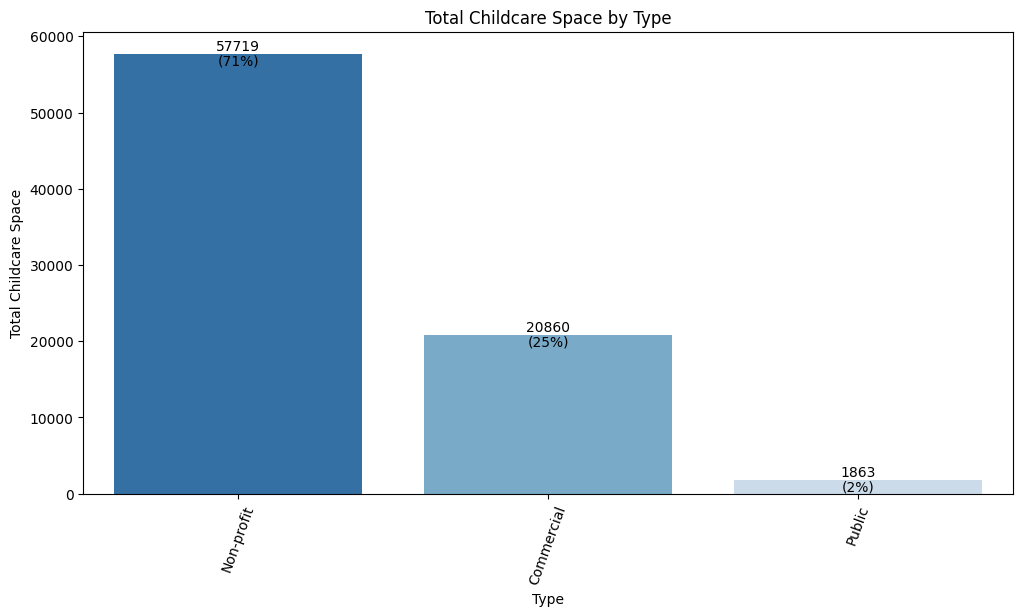

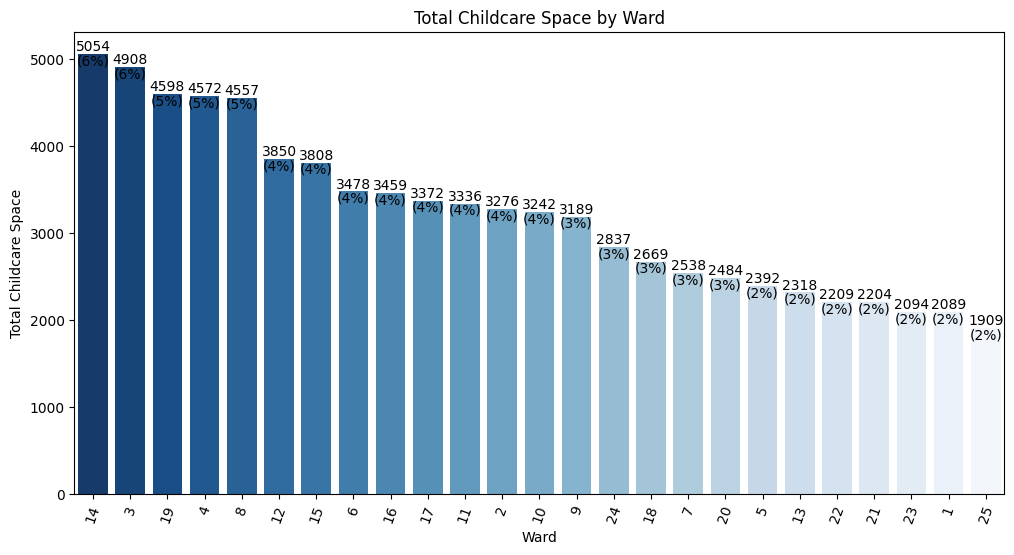

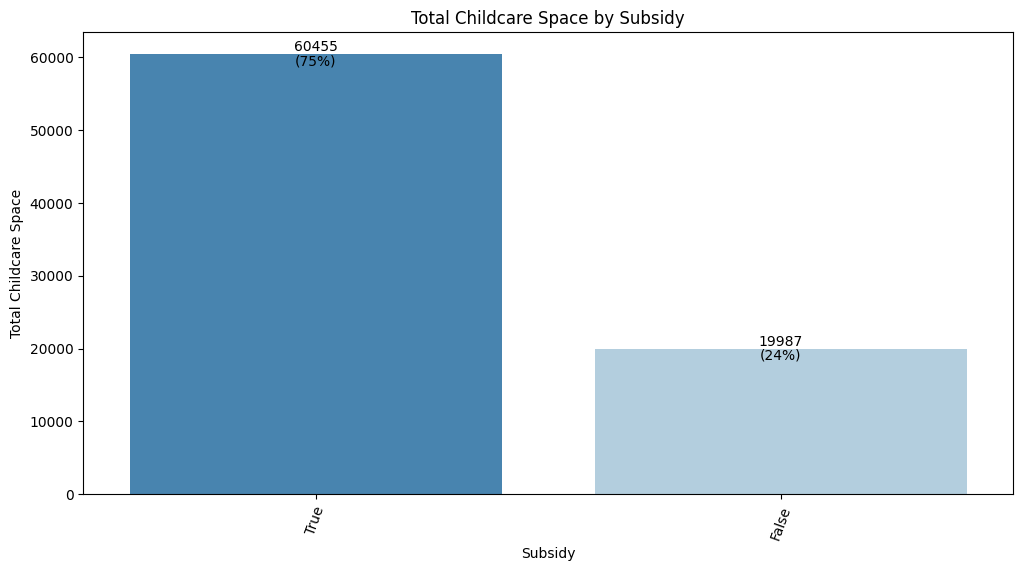

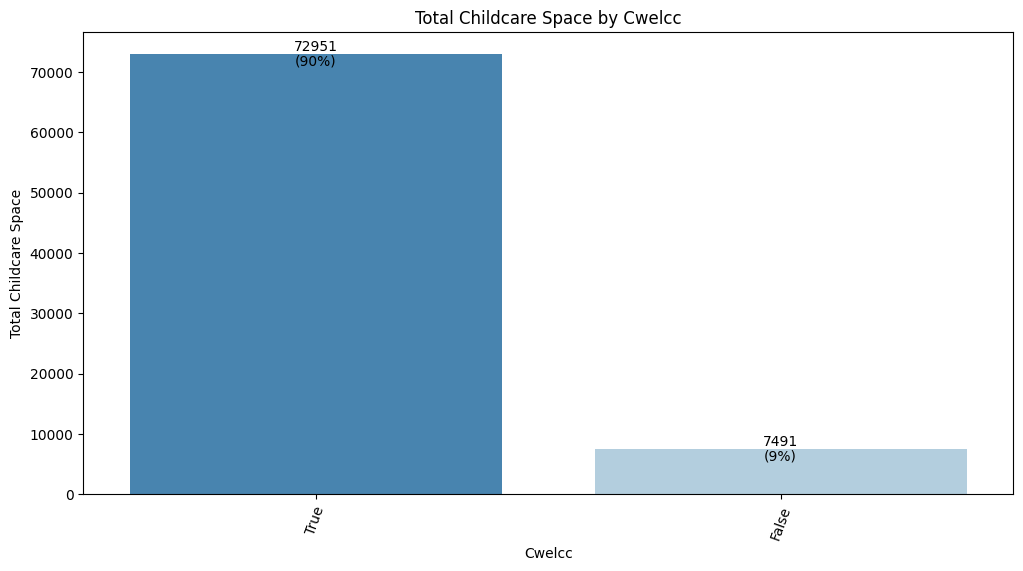

In [23]:
# Count and visualize the distribution of class for categorical variables
for column in ['type', 'ward','subsidy','cwelcc']:
    df_column = df.groupby(column)['total_space'].sum().reset_index().rename(columns={'total_space': "Total Space"})[0:25]

    # Sort based on Total Space
    df_column = df_column.sort_values(by='Total Space', ascending=False)
    df_column[column] = df_column[column].astype(str)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    pal = sns.color_palette("Blues_r", len(df_column))
    bars = sns.barplot(x=column, y='Total Space', palette = pal, ax=ax, data = df_column)

    plt.xticks(rotation=70)
    plt.title(f'Total Childcare Space by {column.capitalize()}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Total Childcare Space')

    # Label each bar with its value count
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                bar.get_height(),
                f'{int(bar.get_height())}',
                ha='center', va='bottom',
                color='black')

        ax.text(bar.get_x() + bar.get_width() / 2.,
                bar.get_height(),
                f'({int((bar.get_height()/df["total_space"].sum())*100)}%)',
                ha='center', va='top',
                color='black')
    # Display the plot
    plt.show()

- 71% of the childcare centres in the dataset is non-profit.
- 75% of the childcare centres are on subsidy.
- 90% of the childcare centres are in the Canada-Wide Early Learning and Child Care (CWELCC) system.
- Ward 14 has the most amount of childcare space among the 25 wards, with 5054 childcare spots, and Ward 25 has the least amount of space for childcare, with a total 1909 childcare spots, less than half of Ward 14's number.

Next step: let's investigate the number and types of childcare **spots** each ward has


In [24]:
df['total_space'].sum()

80442

In [25]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming 'df' is your DataFrame
# # Group by 'type' and sum 'total_space'
# sum_total_space_by_type = df.groupby('subsidy')['total_space'].sum().reset_index()

# # Plot
# plt.figure(figsize=(10, 6))  # Make the figure wider
# sns.barplot(x='subsidy', y='total_space', data=sum_total_space_by_type, palette='coolwarm')
# plt.title('Sum of Total Space by Type')
# plt.xlabel('Type of Childcare Center')
# plt.ylabel('Sum of Total Space')
# plt.show()


### Histogram of total_space

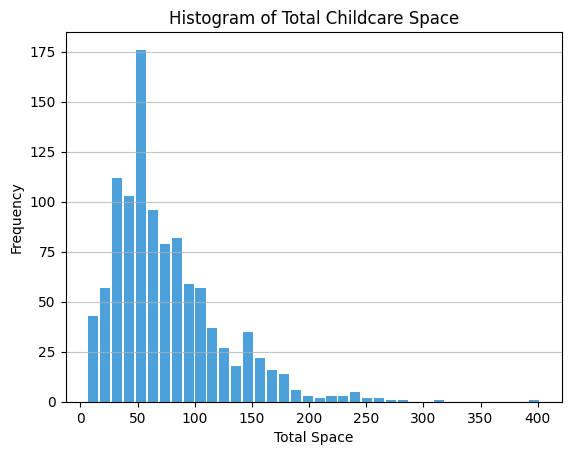

In [26]:
# histogram of total_space
plt.hist(df['total_space'], bins='auto', color='#007acc', alpha=0.7, rwidth=0.85)
plt.xlabel('Total Space')
plt.ylabel('Frequency')
plt.title('Histogram of Total Childcare Space')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [27]:
df[df['total_space']>=250]

name        type  ward  \
96                  Central Eglinton Childrens' Centre  Non-profit    12   
109                     Davisville Care Programme Inc.  Non-profit    12   
300                                   McGregor Jr Ymca  Non-profit    14   
325                                   Allenby Day Care  Non-profit     8   
354              Heath And Ferndale Child Care Program  Non-profit    12   
385                            Maurice Cody Child Care  Non-profit    15   
933  The Neighbourhood Group Canoe Landing Before A...  Non-profit    10   

     infant  toddler  preschool  kindergarden  schoolage  total_space  \
96        0       15         48            91        120          274   
109      10       20         32           104        150          316   
300       0        0         38            78        135          251   
325       0       15         16            78        150          259   
354       0       15         48            78        120          261   
385       0        0          0           117        285          402   
933       0        0          0           130        150          280   

     subsidy  cwelcc  infant_%  toddler_%  preschool_%  kindergarden_%  \
96      True    True      0.00       5.47        17.52           33.21   
109     True    True      3.16       6.33        10.13           32.91   
300     True    True      0.00       0.00        15.14           31.08   
325     True    True      0.00       5.79         6.18           30.12   
354     True    True      0.00       5.75        18.39           29.89   
385     True   False      0.00       0.00         0.00           29.10   
933     True    True      0.00       0.00         0.00           46.43   

     schoolage_%  
96         43.80  
109        47.47  
300        53.78  
325        57.92  
354        45.98  
385        70.90  
933        53.57

All childcare centerd with over 250 total spaces are non-profit. Let's look into childcare center auspice types.

## By Auspice Type

In [28]:
print("\nAverage childcare space by Auspice Type:\n")
df.groupby('type')['total_space'].mean().round(1)


Average childcare space by Auspice Type:



type
Commercial    65.0
Non-profit    82.1
Public        47.8
Name: total_space, dtype: float64

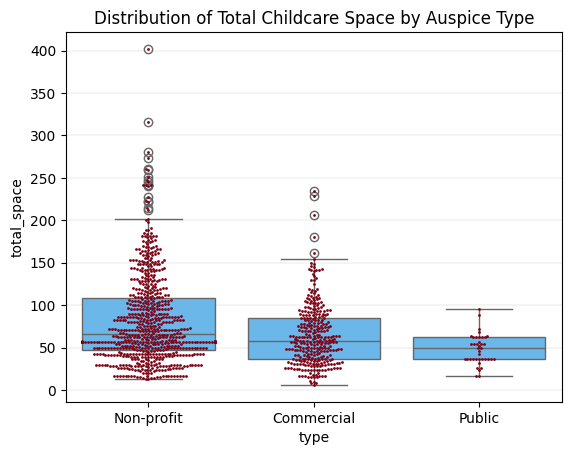

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a boxplot to see the data distribution by 'type'
ax = sns.boxplot(x='type', y='total_space', data=df, color='#56bbff')

# Overlay swarmplot to show the individual data points #99c2a2
ax = sns.swarmplot(x="type", y="total_space", data=df, color='#7d0013',size=2)

ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

plt.title('Distribution of Total Childcare Space by Auspice Type')
plt.show()

## One-way ANOVA Childcare Space ~ Auspice Type

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
%pip install bioinfokit
from bioinfokit.analys import stat

# Conduct one-way ANOVA for 'type'
anova_auspice = ols('total_space ~ C(type)', data=df).fit()
anova_auspice_table = sm.stats.anova_lm(anova_auspice, typ=2)


anova_auspice_table

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.3-py3-none-any.whl size=59056 sha256=f472ddadf3a31c9e2431f87b841eb108dbcd589f017ff1f1436de9d2df783469
  Stored in directory: /root/.cache/pip/wheels/ac/67/a7/4e0b4172d5415933127e819d7d7080ae08a6220949ad2f6de5
Successfully built bioinfokit


sum_sq      df          F        PR(>F)
C(type)   9.611211e+04     2.0  21.843051  5.057716e-10
Residual  2.332065e+06  1060.0        NaN           NaN

In [31]:
res = stat()
res.anova_stat(df=df, res_var='total_space', anova_model='total_space ~ C(type)')
res.anova_summary

df        sum_sq       mean_sq          F        PR(>F)
C(type)      2.0  9.611211e+04  48056.057145  21.843051  5.057716e-10
Residual  1060.0  2.332065e+06   2200.061571        NaN           NaN

AUSPICE TYPE

The sum of squares between groups is approximately 96,112.
The degrees of freedom (df) between groups is 2, which is expected given there are three types of agencies.
The F-statistic value is 21.843, and the p-value is approximately 5.06e-10.
The p-value is much lower than 0.05, which indicates that there is a statistically significant difference in the total childcare space ('TOTSPACE') among the different types of agencies ('AUSPICE').

### Post-hoc analysis using Tukey's HSD

In [32]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform post-hoc analysis using Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['total_space'], groups=df['type'], alpha=0.05)

# Show the results of the Tukey's HSD test
tukey.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

Commercial vs. Non-profit: The mean difference in total childcare spaces is 17.1194, with the p-value adjusted for multiple comparisons being 0.0. This result is statistically significant (as indicated by "reject" being True), meaning that commercial childcare centers tend to have, on average, 17 more spaces than non-profit centers, and this difference is not due to random chance.

Commercial vs. Public: The mean difference here is -17.2152, but the adjusted p-value is 0.0779, which is above the typical alpha level of 0.05. This means that there is not enough evidence to declare a statistically significant difference in the number of childcare spaces between commercial and public agencies. The "reject" column being False supports this.

Non-profit vs. Public: The mean difference is -34.3346, with an adjusted p-value of 0.0. This result is statistically significant, indicating that non-profit childcare centers have significantly fewer spaces on average than public ones, with a mean difference of 34 spaces.

From this data, we've learned that:

There is a significant difference in the number of total childcare spaces between commercial and non-profit agencies, with commercial agencies having more.
There is also a significant difference between non-profit and public agencies, with public agencies having more spaces.
The difference in total childcare spaces between commercial and public agencies was not significant, even though the mean difference suggests that public agencies might have slightly more spaces on average.

In [33]:
# # Create a function to explore data distribution
# def explore_feature_distribution(x,y):

#   # sort the boxes using group occupancy rate mean in ascending order
#   index_sort = df.groupby(x)[y].mean().sort_values().index

#   # set whis = 3 for less aggressive outlier detection
#   sns.boxplot(data = df, x = x, y = y, hue = x, whis = 3, medianprops={'color': 'red'}, order=index_sort)


#   plt.title(f'Distribution of {y} by {x}')
#   plt.xlabel(x)
#   plt.ylabel(y)

#   plt.tight_layout()

#   plt.show()

### Check Assumptions for ANOVA

#### Q-Q Plot


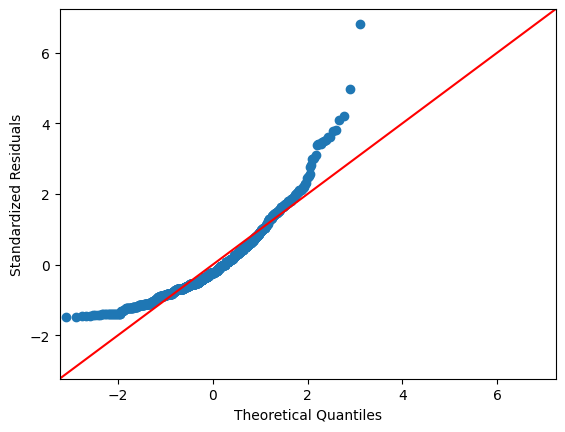

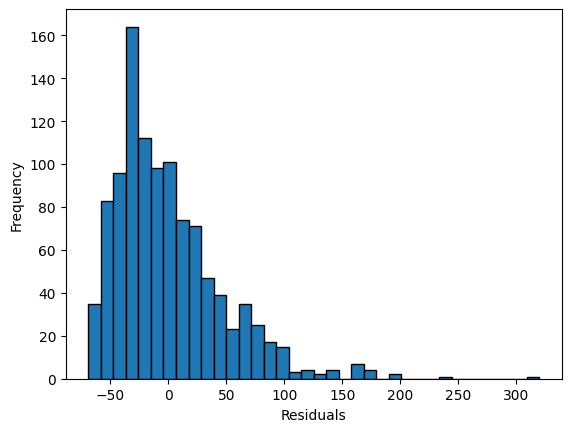

In [34]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import lilliefors

# Assumption 1: Independence
# res.anova_std_residuals are standardized residuals obtained from ANOVA
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()


Q-Q Plot: The Q-Q plot shows the standardized residuals from the ANOVA analysis plotted against the theoretical quantiles of a standard normal distribution. If the residuals were perfectly normally distributed, they would lie on the red line. However, we see a deviation, especially in the tails, suggesting that the residuals have heavier tails than a normal distribution would have. This indicates that there are outliers or extreme values that are not captured by the model.

Histogram: The histogram shows the distribution of residuals. Ideally, if the residuals were normally distributed, the histogram would resemble a bell curve. Instead, the histogram is right-skewed, which means there are more extreme values on the right side of the distribution. This skewness can affect the validity of the ANOVA results because ANOVA assumes that the residuals are normally distributed.

Both plots suggest that the normality assumption of ANOVA may be violated due to the presence of outliers or a non-normal distribution of residuals. This could affect the ANOVA's F-test's ability to correctly identify the significance of the effects due to a potential increase in the Type I or Type II error rates.

#### Shapiro Wilk Test for Normality

In [35]:
# Assumption 2: Normality
# Using Shapiro-Wilk test to test the residuals of the ANOVA model
w, p_value = stats.shapiro(anova_auspice.resid)

# Print out the test statistics and p-values
print("Shapiro-Wilk Test test statistics:", w)
print("Shapiro-Wilk Test p-value:", p_value)

Shapiro-Wilk Test test statistics: 0.901775598526001
Shapiro-Wilk Test p-value: 1.4964898448030214e-25


The test statistic w is 0.901775598526001, which is less than 1. In a perfectly normal distribution, w would be approximately equal to 1.


The p-value is very small (1.4964898448030214e-25), which is practically zero.

This indicates that we should reject the null hypothesis of the Shapiro-Wilk test, which states that the data is normally distributed. With the p-value being extremely small, we can confidently conclude that the residuals of your ANOVA model do not follow a normal distribution. This suggests that the normality assumption of ANOVA has been violated, which can potentially invalidate the results of the ANOVA.

For next steps, we should consider data transformations.

In [36]:
# Assumption 3: Homogeneity of variances
# Using Levene's Test (since data is not normally distributed)
stat, p_val = stats.levene(df[df['type'] == 'Commercial']['total_space'],
                           df[df['type'] == 'Non-profit']['total_space'],
                           df[df['type'] == 'Public']['total_space'])

print("Levene's Test p-value:", p_val)

Levene's Test p-value: 2.2036889276494363e-08


The p-value from Levene's test is extremely small (2.2036889276494363e-08), much less than any conventional alpha level (e.g., 0.05 or 0.01). This means that we can reject the null hypothesis of equal variances across the three groups (Commercial, Non-profit, and Public).

This suggests that the variances of 'total_space' are significantly different between at least two of the groups of childcare types. This inequality of variance could affect the validity of the ANOVA results.

It seems that we should be using the non-parametric ANOVA (Kruskal-Wallace)


In [37]:
### Kruskal-Wallace Test
commercial = df[df['type'] == 'Commercial']['total_space']
nonprofit = df[df['type'] == 'Non-profit']['total_space']
public = df[df['type'] == 'Public']['total_space']


# Perform the Kruskal-Wallis H test
stat, p = stats.kruskal(commercial, nonprofit, public)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the p-value
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=36.342, p=0.000
Different distributions (reject H0)


There is is very strong evidence to reject the null hypothesis of equal means across the different childcare center auspice types. In other words, there is a statistically significant difference in the total childcare spaces (total_space) between at least some of the groups defined by type (Commercial, Non-profit, and Public)

### Post-hoc Test for Non-paramedic Data

Since we have evidence to reject the equal variance assumption, we need to perform a post-hoc test that is appropriate for data with non-normal distribution and unequal variance, like Games Howell post-hoc test

In [ ]:
%pip install pingouin
import pingouin as pg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
games_howell = pg.pairwise_gameshowell(data=df, dv='total_space', between='type')
games_howell

## By Subsidy

In [ ]:
type_levels = df['type'].unique()
ward_levels = df['ward'].unique()

In [ ]:
# Generate a boxplot to see the data distribution by 'type'
ax = sns.boxplot(x='subsidy', y='total_space', data=df, color='#56bbff')

# Overlay swarmplot to show the individual data points #99c2a2
ax = sns.swarmplot(x="subsidy", y="total_space", data=df, color='#7d0013',size=2)

ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

plt.title('Distribution of Total Childcare Space by Subsidy Status')
plt.show()

In [ ]:
print("\nAverage childcare space by Subsidy:\n")
df.groupby('subsidy')['total_space'].mean().round(1)

The averages of childcare space by subsidy status tell us that there's a significant difference in the average total childcare space between centers that offer subsidies (84.2) and those that do not (57.9). This suggests that subsidy status might be an important factor influencing the availability of childcare space.

### One-way ANOVA: Total Space ~ Subsidy

In [ ]:
### Kruskal-Wallace Test
subsidy = df[df['subsidy'] == True]['total_space']
nosubsidy = df[df['subsidy'] == False]['total_space']

# Perform the Kruskal-Wallis H test
stat, p = stats.kruskal(subsidy, nosubsidy)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the p-value
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

In [ ]:
games_howell = pg.pairwise_gameshowell(data=df, dv='total_space', between='subsidy')
games_howell

There's a statistically significant difference in the mean total childcare space between centers that offer subsidies and those that don't, with subsidized centers having more space on average.
The effect size (Hedges' g) suggests a moderate to large difference between the groups, indicating that the difference is not only statistically significant but also practically significant.
Given the very low p-value, we can be highly confident in the reliability of these results under the test's assumptions.

### Total childcare Space ~ Subsidy and Type

Why do subsidized centers have more space?

To explore other variables that might influence total space or interact with subsidy status, a two-way ANOVA can help understand if there an interaction effection between auspice type and subsidy on total childcare space.

#### Two-way ANOVA

In [ ]:
# Create an OLS model with interaction between 'type' and 'subsidy'
model = ols('total_space ~ C(type) + C(subsidy) + C(type):C(subsidy)', data=df).fit()

# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

The significant main effect of subsidy status confirms that it is an important factor in determining total space, independent of the type of center.
The significant interaction effect suggests that the impact of subsidies on total space is not uniform across all types of childcare centers. Some types may benefit more from subsidies in terms of total space than others.

#### Interaction Plot

In [ ]:
# Create interaction plot for 'type' and 'ward' on 'total_space'
interaction_plot = sm.graphics.interaction_plot(x=df['type'],
                                                trace=df['subsidy'],
                                                response=df['total_space'],
                                                colors=['red', 'blue'])
plt.show()

In [ ]:
df[(df['subsidy']==False) & (df['type']=='Public')]

Since there are no public, non-subsidized centers, the analysis of how subsidy status affects total space focused on the groups that do exist, by comparing non-subsidized public centers with subsidized and non-subsidized centers of other types.

#### Post-hoc Test

In [ ]:
%pip install scikit_posthocs

In [ ]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Segmentation
groups = {
    'Subsidized Public': df[(df['type'] == 'Public') & (df['subsidy'] == True)]['total_space'],
    'Subsidized Commercial': df[(df['type'] == 'Commercial') & (df['subsidy'] == True)]['total_space'],
    'Non-subsidized Commercial': df[(df['type'] == 'Commercial') & (df['subsidy'] == False)]['total_space'],
    'Subsidized Non-profit': df[(df['type'] == 'Non-profit') & (df['subsidy'] == True)]['total_space'],
    'Non-subsidized Non-profit': df[(df['type'] == 'Non-profit') & (df['subsidy'] == False)]['total_space']
}

# Kruskal-Wallis Test
stat, p = kruskal(*groups.values())
print(f"Kruskal-Wallis Test: Statistics={stat}, p={p}")

In [ ]:
# Proceed with Dunn's Test for pairwise comparisons since result is statistically significant
if p < 0.05:
    posthoc_results = sp.posthoc_dunn([data for data in groups.values()], p_adjust='bonferroni')
    posthoc_results.columns = list(groups.keys())

posthoc_results


Subsidized Commercial vs. Subsidized Non-profit and Non-subsidized Commercial vs. Non-subsidized Non-profit both indicated no significant difference in the total space between subsidized or non-subsidized commercial and non-profit centers.

However, subsidized public childcare centers vs subsidized commercial and subsidized non-prodit centered both extremely small p-values, indicating statistically dignificant differences in the total spce between subsidized public centers and other types of subsidized centers.

The effect of subsidy on commercial and non-profit childcare centers is not very significant. However, subsidized public centers differ significantly from both subsidized commercial and non-profit centers, which shows the need for further investigation into the factors driving these differences, potentially informing policy decisions regarding childcare subsidies and center operations.

### Total childcare Space ~ Subsidy and Cwelcc

#### Interaction Plot

In [ ]:
# Create interaction plot for 'type' and 'ward' on 'total_space'
interaction_plot = sm.graphics.interaction_plot(x=df['subsidy'],
                                                trace=df['cwelcc'],
                                                response=df['total_space'],
                                                colors=['red', 'blue'])
plt.show()

The lines representing CWELCC status are not parallel, suggesting that there may be an interaction effect between CWELCC status and subsidy status on the mean total childcare space. This means the effect of one factor may depend on the level of the other factor

For childcare centers with CWELCC status as True, the mean total childcare space increases slightly when subsidies are provided. However, the increase in mean total childcare space appears to be much more pronounced in centers without CWELCC status when subsidies are provided, compared to those with CWELCC status.

#### Two-way ANOVA

In [ ]:
# Create an OLS model with interaction between 'type' and 'subsidy'
model = ols('total_space ~ C(cwelcc) + C(subsidy) + C(cwelcc):C(subsidy)', data=df).fit()

# Perform the two-way ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

Subsidy status is a significant predictor of total childcare space, which could be an important policy finding.
There is an interaction between CWELCC status and subsidy, which suggests that the presence or absence of subsidies impacts the total space available in centers with CWELCC status differently compared to those without it. This could indicate that policies around subsidies and CWELCC might need to consider this interaction to understand their full impact on childcare spaces.


### Effect Analysis

The slope of the line for centers with CWELCC status is steeper than the slope for centers without CWELCC status, indicating that the presence of subsidies might have a more substantial impact on the increase in mean total childcare space for centers without CWELCC status.

## By Ward

## Childcare Space by Ward

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Generate a boxplot to see the data distribution by 'type'
ax = sns.boxplot(x='ward', y='total_space', data=df, color='#56bbff')

# Overlay swarmplot to show the individual data points
ax = sns.swarmplot(x="ward", y="total_space", data=df, color='#7d0013',size=2)

ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

plt.title('Distribution of Total Childcare Space by Ward')
plt.show()

At first glace, the average childcare space ranges from as low as 56.6 in Ward 22 to as high as 87.1 in Ward 14, indicating a notable variation in childcare space across the city.

In [ ]:
print("\nAverage childcare space by Ward:\n")
df.groupby('ward')['total_space'].mean().round(1)

In [ ]:
# Aggregate the data by 'ward' and 'type', summing up the 'total_space'
agg_df = df.groupby(['ward','type']).agg({'total_space':'mean'}).reset_index()

In [ ]:
# Create a pivot table
pivot_df = agg_df.pivot(index='ward',columns='type',values='total_space')
# pivot_df

In [ ]:
# Plotting
pivot_df.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title('Total Childcare Space by Auspice Type and Ward')
plt.xlabel('Ward Number')
plt.ylabel('Total Childcare Space')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()

plt.show()

## Total childcare Space ~ Ward

### One-way ANOVA Childcare Space ~ Ward

In [ ]:
# Conduct one-way ANOVA for 'ward'
anova_ward = ols('total_space ~ C(ward)', data=df).fit()
anova_ward_table = sm.stats.anova_lm(anova_ward, typ=2)

anova_ward_table



WARD

The sum of squares between groups is approximately 78,598.
The degrees of freedom (df) between groups is 24, which corresponds to the 25 wards.
The F-statistic value is 1.447, and the p-value is approximately 0.076.
The p-value for the wards is slightly above the 0.05 threshold, indicating that there is not a statistically significant difference in the total childcare space ('TOTSPACE') across different wards at the traditional 5% significance level. However, it is close enough to warrant further investigation, perhaps with a larger sample or a different significance level.

## Total Childcare Space ~ Type and Ward

### Interaction Plot

In [ ]:
# Create interaction plot for 'type' and 'ward' on 'total_space'
interaction_plot = sm.graphics.interaction_plot(x=df['ward'],
                                                trace=df['type'],
                                                response=df['total_space'],
                                                colors=['red', 'blue', 'green'])
plt.show()

## Two-way ANOVA: Total Childcare Space ~ Subsidy and Ward

### Interaction Plot

In [ ]:
# Create interaction plot for 'type' and 'ward' on 'total_space'
interaction_plot = sm.graphics.interaction_plot(x=df['ward'],
                                                trace=df['subsidy'],
                                                response=df['total_space'],
                                                colors=['red', 'blue'])
plt.show()